In [149]:
from typing import Any, Dict, Iterable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Reference notebook: [Survival Analysis for Deep Learning](https://colab.research.google.com/github/sebp/survival-cnn-estimator/blob/master/tutorial_tf2.ipynb).

# Generate data

In [122]:
N_COVAR = 3

In [123]:
def gen_data(
  n: int,
  base_rate=0.50,
  cens_prop=0.20,
  n_covar=N_COVAR,
  n_freq=3,
  tau=4,
) -> Dict[str, np.ndarray]:
  """Generate data.
  
  Args:
    n: Sample size.
    base_rate: Base event rate.
    cens_prop: Expected censoring proportion.
    n_covar: Number of covariates.
    n_freq: Number of frequencies.
    tau: Truncation time.
  
  """

  # Sinusoidal basis.
  x = np.random.rand(n, n_covar)
  cols = []
  for i in range(n_covar):
    for f in range(1, n_freq + 1):
      cols.append(np.sin(2 * np.pi * x[:, i] * f))
      cols.append(np.cos(2 * np.pi * x[:, i] * f))
  basis = np.transpose(np.vstack(cols))
  n_col = basis.shape[1]
  
  # Linear predictor.
  coef = np.random.randn(n_col)
  eta = np.dot(basis, coef)
  eta = (eta - np.mean(eta)) / np.std(eta)

  # Time-to-event.
  event_rate = base_rate * np.exp(eta)
  event_time = np.random.exponential(scale=1/event_rate, size=len(event_rate))

  cens_rate = (1 - cens_prop) / cens_prop * event_rate 
  cens_time = np.random.exponential(scale=1/cens_rate, size=len(cens_rate))
  cens_time = np.where(cens_time > tau, tau, cens_time)

  status = (event_time <= cens_time)
  time = np.where(status, event_time, cens_time)

  # Output.
  return {
    "x": x,
    "risk": event_rate,
    "status": status,
    "time": time,
  }

In [171]:
def split_data(
  data: Dict[str, np.ndarray],
  train_prop: float = 0.8,
) -> Dict[str, np.ndarray]:

  n = len(data["time"])
  n_train = int(train_prop * n)

  out = {}
  for key in data.keys():
    out[f"train_{key}"] = data[key][:n_train]
    out[f"val_{key}"] = data[key][n_train:]
  
  return out

# Kaplan-Meier

## Build masks

In [125]:
def build_masks(status: np.ndarray, time: np.ndarray) -> Tuple[np.ndarray]:
  """Build masks.

  Create unique-time (row) by subject (col) boolean masks.

  Returns:
    at_risk: [t, i] = True if subject i is at risk at time t.
    cens: [t, i] = True if subject is is censored at time t.
    event: [t, i] = True if subject i has an event at time t.
    unique_times: Unique times corresponding to the rows.

  """
  n_subj = len(time)

  # Add 0 if not present.
  unique_times = np.sort(np.unique(time))
  if not (0 in unique_times):
    unique_times = np.insert(unique_times, 0, 0)
  n_unique_time = len(unique_times)

  # Masks.
  at_risk = np.zeros(shape=(n_unique_time, n_subj), dtype=bool)
  cens = np.zeros(shape=(n_unique_time, n_subj), dtype=bool)
  event = np.zeros(shape=(n_unique_time, n_subj), dtype=bool)

  for i in range(n_subj):
    at_risk[:, i] = (time[i] >= unique_times)
    which_time = (unique_times == time[i])
    cens[:, i] = (not status[i]) * which_time
    event[:, i] = status[i] * which_time

  return at_risk, cens, event, unique_times

In [126]:
n = 5
status = np.array(np.round(np.random.rand(n)), dtype=bool)
time = np.arange(n, dtype=float)

In [127]:
print("Status:")
print(status)
print("\n")
print("Time:")
print(time)

Status:
[False False  True False  True]


Time:
[0. 1. 2. 3. 4.]


In [128]:
at_risk, cens, event, unique_times = build_masks(status, time)

In [129]:
print("At risk:")
print(at_risk)

At risk:
[[ True  True  True  True  True]
 [False  True  True  True  True]
 [False False  True  True  True]
 [False False False  True  True]
 [False False False False  True]]


In [130]:
print("Censored:")
print(cens)

Censored:
[[ True False False False False]
 [False  True False False False]
 [False False False False False]
 [False False False  True False]
 [False False False False False]]


In [131]:
print("Event:")
print(event)

Event:
[[False False False False False]
 [False False False False False]
 [False False  True False False]
 [False False False False False]
 [False False False False  True]]


## Tabulate KM

In [132]:
def tab_km(status: np.ndarray, time: np.ndarray) -> pd.DataFrame:
  """Taublate Kaplan-Meier."""
  at_risk, cens, event, unique_times = build_masks(status, time)

  out = pd.DataFrame({
    "time": unique_times,
    "n_at_risk": np.sum(at_risk, axis=1),
    "n_event": np.sum(event, axis=1),
    "n_cens": np.sum(cens, axis=1),
  })
  out["haz"] = out.n_event / out.n_at_risk
  out["surv"] = np.cumprod(1 - out.haz)
  return out  

## Estimator

In [213]:
class KaplanMeier:

  def __init__(self, status: np.ndarray, time: np.ndarray) -> None:
    self.status = status
    self.time = time
    self.km = tab_km(self.status, self.time)
  
  def return_table(self) -> pd.DataFrame:
    return self.km
    
  def __call__(self, x: float) -> float:
    km = self.km
    return km.surv[np.max(np.where(km.time <= x))]

In [214]:
# Fit Kaplan-Meier.
km = KaplanMeier(
  status = np.array([True, False, True, False]),
  time = np.arange(1, 5)
)
km.return_table()

,time,n_at_risk,n_event,n_cens,haz,surv
0,0,4,0,0,0.00,1.000
1,1,4,1,0,0.25,0.750
2,2,3,0,1,0.00,0.750
3,3,2,1,0,0.50,0.375
4,4,1,0,1,0.00,0.375


In [284]:
# Evaluate Kaplan-Meier.
km(1.1)

0.75

# C-statistic

* Reference: [On the C-statistics for Evaluating Overall Adequacy of Risk Prediction Procedures with Censored Survival Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3079915/).

In [216]:
class Concord:
  """Calculate concordance.
  
  Note that the Kaplan-Meier curve of the censoring distribution may be fit
  using different data from that used to calculate the C-statistic.
  
  """

  def __init__(self, status: np.ndarray, time: np.ndarray) -> None:
    self.km = KaplanMeier(~status, time)
  
  def __call__(
    self,
    risk: np.ndarray,
    status: np.ndarray,
    time: np.ndarray,
    tau=None
  ) -> float:

    n = len(risk)
    upper = 0
    lower = 0

    if not tau:
      tau = np.max(time)

    for i in range(n):
      di, ti, ri = status[i], time[i], risk[i]

      # Only cases contribute.
      if not di:
        continue

      for j in range(n):
        tj, rj = time[j], risk[j]
        denom = di * (ti < tj) * (ti < tau)

        # Only calculate censoring weights if denom is non-zero.
        if denom:
          p_cens = np.squeeze(self.km(ti))
          weight = 1 / (p_cens ** 2)
          upper += denom * weight * (ri > rj)
          lower += denom * weight

    return upper / lower if lower > 0 else 0.5

In [217]:
risk = np.array([4, 3, 2, 1])
status = np.array([True, True, False, True])
time = np.array([1, 2, 3, 4])
cstat = Concord(status, time)
cstat(risk, status, time)

1.0

# Proportional hazards loss

In [218]:
class CoxLoss(tf.keras.losses.Loss):

  def __init__(self, **kwargs):
    super().__init__(**kwargs) 
  
  def call(
      self,
      y_true: Tuple[tf.Tensor],
      y_pred: tf.Tensor
  ) -> tf.Tensor:
    """Calculate Cox PH Loss.
    
    Args:
      y_true: (at_risk, event).
      y_pred: risk.

    """
    
    at_risk, event = y_true
    risk_score = tf.squeeze(y_pred)
    
    at_risk_cast = tf.cast(at_risk, y_pred.dtype)
    event_cast = tf.cast(event, y_pred.dtype)

    num = tf.reduce_sum(tf.math.multiply(event_cast, risk_score), axis=1)
    denom = tf.reduce_logsumexp(tf.math.multiply(at_risk_cast, risk_score), axis=1)
    
    return -1 * tf.reduce_sum(tf.subtract(num, denom))

# Cox Model

## Data preparation

In [219]:
class InputFunction:
  
  def __init__(
    self,
    status: np.ndarray,
    time: np.ndarray,
    x: np.ndarray,
    batch_size=128,
    seed=101,
    shuffle=True,
  ) -> None:
    self.batch_size = batch_size
    self.n = x.shape[0]
    self.seed = seed
    self.shuffle = shuffle
    self.status = status
    self.steps_per_epoch = self.n // batch_size
    self.time = time
    self.x = x
  
  def get_batch(
      self, index: np.ndarray) -> Tuple[np.ndarray, Tuple[np.ndarray]]:
    x = self.x[index]
    status = self.status[index]
    time = self.time[index]
    at_risk, _, event, _ = build_masks(status, time)
    return x, (at_risk, event)
  
  def generator(self) -> Iterable[Tuple[np.ndarray, Tuple[np.ndarray]]]:
    """Data generator.

    Note that if the data set size is not evenly divisible by the batch
    size, the last batch is dropped.
    
    """
    index = np.arange(self.n)
    rnd = np.random.RandomState(self.seed)

    if self.shuffle:
      rnd.shuffle(index)
    for b in range(self.steps_per_epoch):
      start = b * self.batch_size
      idx = index[start:(start + self.batch_size)]
      yield self.get_batch(idx)

  def make_dataset(self) -> tf.data.Dataset:
    """Create dataset from generator."""
    batch_size = self.batch_size
    n_covar = self.x.shape[1]

    ds = tf.data.Dataset.from_generator(
      self.generator,
      output_signature=(
        tf.TensorSpec(shape=(batch_size, n_covar), dtype=tf.float32),
        (tf.TensorSpec(shape=(None, batch_size), dtype=tf.float32), 
         tf.TensorSpec(shape=(None, batch_size), dtype=tf.float32))
      )
    )
    return ds
  
  def __call__(self) -> tf.data.Dataset:
    return self.make_dataset()

In [220]:
def prep_datasets(
  n,
  n_covar=N_COVAR,
  train_prop=0.8,
) -> Dict[str, Any]:
  data = split_data(gen_data(n=n, n_covar=n_covar), train_prop)
  keys = ["train", "val"]
  out = {}
  for key in keys:
    status = data[f"{key}_status"]
    time = data[f"{key}_time"]
    x = data[f"{key}_x"]
    input_fn = InputFunction(status, time, x)
    out[f"{key}_ds"] = input_fn()
  out["data"] = data
  return out

## Proportional hazards

In [258]:
class FitCoxModel:

  def __init__(
    self, 
    model,
    train_ds,
    val_ds,
    init_epoch=0,
    epochs=100,
    results_dir=None,
  ) -> None:
    """

    Notes:
    * Batch size is controlled by the InputFunction. 
    * `train_ds` and `val_ds` are provided as Tensorflow datasets.
    
    """
    self.current_epoch = init_epoch
    self.epochs = epochs
    self.model = model
    self.results_dir = results_dir
    self.train_ds = train_ds
    self.val_ds = val_ds

    self.optimizer = tf.keras.optimizers.Adam()
    self.loss_fn = CoxLoss()
    
    self.train_loss = tf.keras.metrics.Mean(name="train_loss")
    self.val_loss = tf.keras.metrics.Mean(name="train_loss")

  @tf.function
  def train_step(self, x, y) -> None:
    with tf.GradientTape() as tape:
      y_pred = self.model(x, training=True)
      loss = self.loss_fn(y, y_pred)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    self.train_loss.update_state(loss)
  
  @tf.function
  def val_step(self, x, y) -> None:
    y_pred = self.model(x, training=False)
    loss = self.loss_fn(y, y_pred)
    self.val_loss.update_state(loss)
  
  def epoch(self, report_freq=10, verbose=True) -> Dict[str, float]:
    self.train_loss.reset_states()
    self.val_loss.reset_states()

    # Loop over training data.
    for x, y in self.train_ds:
      self.train_step(x, y)
    
    # Loop over validation data.
    for x, y in self.val_ds:
      self.val_step(x, y)
    
    train_loss = self.train_loss.result()
    val_loss = self.val_loss.result()

    # Report.
    if verbose:
      if (self.current_epoch % report_freq) == 0:
        print(f"""
          Epoch {self.current_epoch},
          Train loss: {train_loss:.3f},
          Validation loss: {val_loss:.3f}
          """)

    # Increment epoch.
    self.current_epoch += 1
    return {
      "epoch": self.current_epoch - 1,
      "train_loss": train_loss.numpy(),
      "val_loss": val_loss.numpy(),
    }
  
  def fit(self, report_freq=10, verbose=True) -> pd.DataFrame:
    out = {"epoch": [], "train_loss": [], "val_loss": []}
    for _ in range(self.epochs):
      losses = self.epoch(report_freq, verbose)

      for key in losses:
        out[key].append(losses[key])
    
    return pd.DataFrame(out)

  def return_model(self) -> tf.keras.Model:
    return self.model

## Example

In [277]:
# Model.
input = tf.keras.layers.Input(shape=(N_COVAR,), name="input")
h = tf.keras.layers.Dense(25, activation="selu", name="dense1")(input)
h = tf.keras.layers.Dropout(0.5, name="drop1")(h)
h = tf.keras.layers.Dense(25, activation="relu", name="dense2")(h)
h = tf.keras.layers.Dropout(0.5, name="drop2")(h)
h = tf.keras.layers.Dense(25, activation="relu", name="dense3")(h)
h = tf.keras.layers.Dropout(0.5, name="drop3")(h)
output = tf.keras.layers.Dense(1, name="output")(h)
model = tf.keras.Model(input, output, name="model")

In [278]:
# Prepare data sets.
ds = prep_datasets(n=128 * 10 * 2)
trainer = FitCoxModel(model, ds["train_ds"], ds["val_ds"])

In [279]:
# Train.
history = trainer.fit()


          Epoch 0,
          Train loss: 639.361,
          Validation loss: 616.893
          

          Epoch 10,
          Train loss: 591.846,
          Validation loss: 586.849
          

          Epoch 20,
          Train loss: 588.202,
          Validation loss: 585.682
          

          Epoch 30,
          Train loss: 586.175,
          Validation loss: 584.913
          

          Epoch 40,
          Train loss: 584.175,
          Validation loss: 584.286
          

          Epoch 50,
          Train loss: 583.090,
          Validation loss: 584.133
          

          Epoch 60,
          Train loss: 583.378,
          Validation loss: 583.923
          

          Epoch 70,
          Train loss: 583.953,
          Validation loss: 583.952
          

          Epoch 80,
          Train loss: 583.167,
          Validation loss: 583.892
          

          Epoch 90,
          Train loss: 581.752,
          Validation loss: 583.857
          


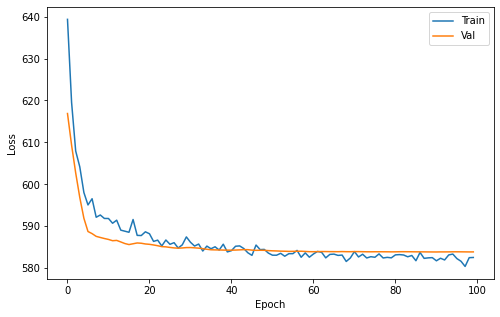

In [280]:
# Plot training history.
melt_history = pd.melt(history, "epoch", var_name="loss", value_name="y")
plt.figure(figsize=(8, 5))
sns.lineplot(data=melt_history, x="epoch", y="y", hue="loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [281]:
# Calculate C statistics.
data = ds["data"]
cstat = Concord(data["train_status"], data["train_time"])

In [282]:
# Optimal C-statistic, based on true event rate.
c_opt = cstat(data["val_risk"], data["val_status"], data["val_time"])
print(f"Optimal C-statistic: {c_opt:.3f}")

Optimal C-statistic: 0.729


In [283]:
# Model C-statistic.
model = trainer.return_model()
risk = np.squeeze(model.predict(data["val_x"]))
c_model = cstat(risk, data["val_status"], data["val_time"])
print(f"Model C-statistic: {c_model:.3f}")

Model C-statistic: 0.557
